# Stochastic ACOPF ADMM Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import itertools
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
import networkx as nx
import time
from copy import deepcopy
import math



from pyomo.environ import *
import pyomo.environ as pyo

In [2]:
def read_data_ACOPF(File='IEEE_14_bus_Data.xlsx',print_data=False,DemFactor=1.0,LineLimit=1.0):
    # read the data file and convert it into a dictionary
    # this function is writeen for multi-time OPF problems

    Sbase=100
    EndTime=23
    T=range(0,EndTime+1)   # T is from [0 to 23]
    data={}

    Bus=pd.read_excel(File,sheet_name='Bus',skiprows=0,index_col=[0],usecols='A')
    Bus=list(Bus.index)                   # for b in Bus


##============================ Branch ========================
# branch is a dataframe that shows r,x,limit of branches
    branch=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=[0,1,2],usecols='A:G')

    for l,i,j in branch.index:
        branch.loc[(l,j,i)]=branch.loc[(l,i,j)] #bi-directional

#     line=pd.read_excel(File,sheet_name='Branch',skiprows=1,index_col=0,usecols='A')
#     line=list(line.index)

    branch['limit']=(LineLimit*branch['limit'])/Sbase


    branch['z2']= branch['r']**2+branch['x']**2
    branch['g_ij']= branch['r']/branch['z2']
    branch['b_ij']= branch['x']/branch['z2']

    branch['z']= np.sqrt(branch['z2'])
    branch['th_ij']=np.arctan(branch['x']/branch['r'])

    # print(branch)


    br_list=list(branch.index)
    Lines=gp.tuplelist(br_list)   #Lines is a gurobipy tupilelist that shows CONECCTIVITY of the network


    L2B=[]   #set all lines connected to bus b


    for l,i,j in Lines:
        L2B=L2B+[(l,i)]

    L2B=gp.tuplelist(L2B)          # Set lines connected to each bus (substation)


    # Demand Set
    # Pdemand is a DF containing demand at all times (we may use only one timeslot from this data)

    Pdemand=pd.read_excel(File,sheet_name='DemandSet',skiprows=1,index_col=2,usecols='A:E')
    Pdemand.drop(columns=['Unnamed: 0','Unnamed: 1'],axis=1,inplace=True)


    Pdemand.rename(columns={1:'Pd'})
    Pdemand.rename(columns={2:'Qd'})
    Pdemand.fillna(0,inplace=True)
    Pdemand['Pd']=(DemFactor*Pdemand['Pd'])/Sbase          # pu
    Qdemand=Pdemand.copy()
    Qdemand['Qd']=(DemFactor*Qdemand['Qd'])/Sbase          # pu

    Pd_nominal=Pdemand['Pd'].to_numpy()
    Qd_nominal=Qdemand['Qd'].to_numpy()




    #define new columns here! Pd[d,t]
    LoadProfile=pd.read_excel(File,sheet_name='LoadProfile',skiprows=0,index_col=0,usecols='A:B')


    for t in LoadProfile.index:
        Pdemand[t]=Pdemand['Pd']*LoadProfile.loc[t]['Pdt']
        Qdemand[t]=Qdemand['Qd']*LoadProfile.loc[t]['Pdt']


    DemandSet=list(Pdemand.index)          #for d in DemandSet

    D2B_df=pd.read_excel(File,sheet_name='D2B',skiprows=0,index_col=[1,2])
    d2b_list=list(D2B_df.index)
    D2B=gp.tuplelist(d2b_list)


    # make Pd_array with all buses:

    Pd_array=np.zeros((len(Bus),len(T)))
    Qd_array=np.zeros((len(Bus),len(T)))


    for d in DemandSet:
        for t in T:
            for dx,b in D2B.select(d,'*'):
                Pd_array[Bus.index(b),t]+=Pdemand.loc[d,t]
                Qd_array[Bus.index(b),t]+=Qdemand.loc[d,t]


    #==================================== Generation data =============
    # Gen_data is a DF that shows generators data

    Gen_data=pd.read_excel(File,sheet_name='Gen',skiprows=2,index_col=0,usecols='A:K')
    Gen_data['Pmax']=Gen_data['Pmax']/Sbase
    Gen_data['Pmin']=Gen_data['Pmin']/Sbase
    Gen_data['RampDn']=Gen_data['RampDn']/Sbase
    Gen_data['RampUp']=Gen_data['RampUp']/Sbase

    Gen_data['a']=Gen_data['a']*Sbase             #The final objective cost should be multiplied with Sbase
    #Gen_data['b']=Gen_data['b']*Sbase
    G=list(Gen_data.index) #Set Generation




    # G2B is a GP object showing Gen-2-bus
    G2B_df=pd.read_excel(File,sheet_name='G2B',skiprows=0,index_col=[1,2])
    g2b_list=list(G2B_df.index)
    G2B=gp.tuplelist(g2b_list)


    


    if print_data==True:
        display(Pdemand)
        display(branch)
        display(Gen_data)
        plt.plot(T,Pdemand.sum(axis=0)[1:])


    data['Sbase']=Sbase
    data['Bus']=Bus    # for b in Bus
    data['branch']=branch
    data['Lines']=Lines
#     data['line']=line
    data['L2B']=L2B
    data['Pdemand']=Pdemand
    data['Demandset']=DemandSet     # for d in Demand_set
    data['D2B']=D2B                  # for d,b in D2B
    data['Gen_data']=Gen_data
    data['G']=G             #for g in Gset
    data['G2B']=G2B               #for g,b in G2B
    data['EndTime']=EndTime
    data['T']=T
    data['Pd_array']=Pd_array
    data['Qd_array']=Qd_array
    data['LoadProfile']=LoadProfile
    data['Pd_nominal']=Pd_nominal
    data['Qd_nominal']=Qd_nominal



    return data



# Non-linear ACOPF 

In [3]:
def create_MultiTime_ACOPF_Cos(data,nT=24,Ramp=True,Tlink=False):

    """Returns the Pg,Qg schedule for a given demand and time horizon
    if Tlink=True, considers the ramping limit to time 0!
    The parameters should be initialized
    """

    #======  data

    Sbase=data['Sbase']
    Bus=data['Bus']    # for b in Bus
    branch=data['branch']
    Lines=data['Lines']
    L2B=data['L2B']
    Pdemand=data['Pdemand']
    DemandSet=data['Demandset']     # for d in Demand_set
    D2B=data['D2B']                  # for d,b in D2B
    Gen_data=data['Gen_data']
    G=data['G']             #for g in Gset
    G2B=data['G2B']               #for g,b in G2B
    EndTime=data['EndTime']
#     T=data['T']
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']


    #======
    EndTime=nT-1
    T=range(0,EndTime+1)
    
    


#====

    model =  ConcreteModel(name='ACOPF')


    model.Pg = Var( G,T,bounds=(0, None) )
    model.Qg = Var( G,T,bounds=(None, None) )
    
    model.Pd = Param(Bus,T,initialize=0, mutable=True)
    model.Qd = Param(Bus,T,initialize=0, mutable=True)
    if Tlink==True:
        model.Pg0 = Param(G,mutable=True)
    
    
    

    model.Vol = Var(Bus,T,bounds=(0, None) )
    model.theta = Var(Bus,T,bounds=(-math.pi/3, math.pi/3), initialize=0 )

    model.Pflow = Var( Lines,T,bounds=(None, None) )
    model.Qflow = Var( Lines,T,bounds=(None, None) )

    model.Rup = Var( G,T,bounds=(0, None) )
    model.Rdn = Var( G,T,bounds=(0, None) )
    model.OF = Var( bounds=(0, None) )




    # equations
    vmin=0.9; vmax=1.1; 



    def eqPbalance(model,b,t):
        return sum( model.Pg[g,t] for g,b in G2B.select('*',b) ) - model.Pd[b,t] \
        == sum(model.Pflow[l,i,j,t] for l,i,j in Lines.select('*',b,'*'))
    model.eqPbalance=Constraint(Bus,T,rule=eqPbalance)


    def eqQbalance(model,b,t):
        return sum( model.Qg[g,t] for g,b in G2B.select('*',b) ) - model.Qd[b,t] \
        == sum(model.Qflow[l,i,j,t] for l,i,j in Lines.select('*',b,'*'))
    model.eqQbalance=Constraint(Bus,T,rule=eqQbalance)



    def eqflow2(model,l,i,j,t):
        return model.Pflow[l,i,j,t] + model.Pflow[l,j,i,t] >= 0
    model.eqflow2=Constraint(Lines,T,rule=eqflow2)

    #soroudi equations
    def eqPij(model,l,i,j,t):
        return model.Pflow[l,i,j,t] == \
        model.Vol[i,t]*model.Vol[i,t]*(1/branch.loc[(l,i,j)]['z'])*cos(branch.loc[(l,i,j)]['th_ij']) \
        -model.Vol[i,t]*model.Vol[j,t]*(1/branch.loc[(l,i,j)]['z'])*cos(model.theta[i,t]-model.theta[j,t]+branch.loc[(l,i,j)]['th_ij'])
    model.eqPij=Constraint(Lines,T,rule=eqPij)

    #
    def eqQij(model,l,i,j,t):
        return model.Qflow[l,i,j,t] == \
        model.Vol[i,t]*model.Vol[i,t]*(1/branch.loc[(l,i,j)]['z'])*sin(branch.loc[(l,i,j)]['th_ij']) \
        -model.Vol[i,t]*model.Vol[j,t]*(1/branch.loc[(l,i,j)]['z'])*sin(model.theta[i,t]-model.theta[j,t]+branch.loc[(l,i,j)]['th_ij'])
        #-model.Vol[i,t]*model.Vol[i,t]*(branch.loc[(l,i,j)]['b']/2)
    model.eqQij=Constraint(Lines,T,rule=eqQij)






    def eqVmax(model,i,t): return model.Vol[i,t]<= vmax
    model.eqVmax=Constraint(Bus,T,rule=eqVmax)

    def eqVmin(model,i,t): return vmin <= model.Vol[i,t]
    model.eqVmin=Constraint(Bus,T,rule=eqVmin)


    def eqPijmax(model,l,i,j,t): 
        return model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]\
        <=branch.loc[(l,i,j)]['limit']**2
    model.eqPijmax=Constraint(Lines,T,rule=eqPijmax)

    def eqPijmin(model,l,i,j,t): 
        return -branch.loc[(l,i,j)]['limit']**2 <=\
        model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]
    model.eqPijmin=Constraint(Lines,T,rule=eqPijmin)



    def eqPgmax(model,g,t): return model.Pg[g,t]<=Gen_data.loc[g]['Pmax']
    model.eqPgmax=Constraint(G,T,rule=eqPgmax)

    def eqPgmin(model,g,t): return Gen_data.loc[g]['Pmin'] <= model.Pg[g,t]
    model.eqPgmin=Constraint(G,T,rule=eqPgmin)

    def eqQgmax(model,g,t): return model.Qg[g,t]<= Gen_data.loc[g]['Qmax']
    model.eqQgmax=Constraint(G,T,rule=eqQgmax)

    def eqQgmin(model,g,t): return Gen_data.loc[g]['Qmin'] <= model.Qg[g,t]
    model.eqQgmin=Constraint(G,T,rule=eqQgmin)

    def eqtheta(model,t):
        return model.theta[Bus[0],t]==0
    model.eqtheta=Constraint(T,rule=eqtheta)
    


    if Ramp==True:
        def eqRU(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t+1]-model.Pg[g,t]<=Gen_data.loc[g]['RampUp']  #+model.Rup[g,t+1]
            else:
                return Constraint.Skip
        model.eqRU=Constraint(G,T,rule=eqRU)
        
        def eqRD(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t]-model.Pg[g,t+1]<=Gen_data.loc[g]['RampDn']  
            else:
                return Constraint.Skip
        model.eqRD=Constraint(G,T,rule=eqRD)
        
        if Tlink==True:
            def eqPg0up(model,g):
                return model.Pg[g,T[0]]-model.Pg0[g]<=Gen_data.loc[g]['RampUp'] 
            model.eqPg0up=Constraint(G,rule=eqPg0up)
            
            def eqPg0dn(model,g):
                return model.Pg0[g] - model.Pg[g,T[0]]<=Gen_data.loc[g]['RampDn'] 
            model.eqPg0dn=Constraint(G,rule=eqPg0dn)




    model.eqOF = Constraint( expr = model.OF == sum(Gen_data.loc[g]['b']*model.Pg[g,t]  \
                                               # +Gen_data.loc[g]['a']*model.Pg[g,t]*model.Pg[g,t]
                                                 + 0.0001*Gen_data.loc[g]['b']*model.Qg[g,t]*model.Qg[g,t] 
                                                    for g in G for t in T) )
    model.obj = Objective( expr = model.OF , sense=pyo.minimize      )



    solver = SolverFactory('ipopt')
    

    return model

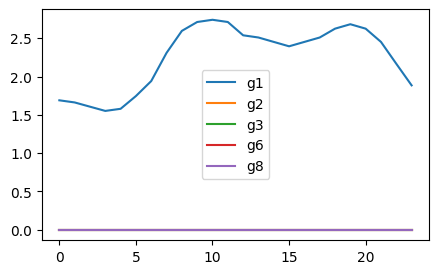

1082.6282041152301


In [5]:
sys=14
nT=24
data=read_data_ACOPF(File=f'IEEE_{sys}_bus_Data_PGLib_ACOPF.xlsx',DemFactor=1.0,print_data=False)
Bus=data['Bus']
G=data['G']

model=create_MultiTime_ACOPF_Cos(data,nT=nT)

for b in data['Bus']:
    for t in range(0,nT):
        model.Pd[b,t].value = data['Pd_array'][Bus.index(b),t]
        model.Qd[b,t].value = data['Qd_array'][Bus.index(b),t]
        
    
solver = SolverFactory('ipopt')
results = solver.solve(model,tee=False)

Pgt_array=np.zeros((len(G),nT))

for ind,g in enumerate(G):
    for t in range(0,nT):
        Pgt_array[ind,t]=model.Pg[g,t].value
        # print(g,t,model.Pg[g,t].value)




plt.figure(figsize=(5,3))
for ind,g in enumerate(G):
    plt.plot(range(0,nT),Pgt_array[ind,:],label=g)
plt.legend()
plt.show()

print( model.OF.value)

# SOCP-based ACOPF

In [6]:
def create_MultiTime_ACOPF_SOCP(data,nT=24,Ramp=True,Tlink=False):

    """Returns the Pg,Qg schedule for a given demand and time horizon
    if Tlink=True, considers the ramping limit to time 0!
    The parameters should be initialized
    """

    #======  data

    Sbase=data['Sbase']
    Bus=data['Bus']    # for b in Bus
    branch=data['branch']
    Lines=data['Lines']
    L2B=data['L2B']
    Pdemand=data['Pdemand']
    DemandSet=data['Demandset']     # for d in Demand_set
    D2B=data['D2B']                  # for d,b in D2B
    Gen_data=data['Gen_data']
    G=data['G']             #for g in Gset
    G2B=data['G2B']               #for g,b in G2B
    EndTime=data['EndTime']
#     T=data['T']
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']


    #======
    EndTime=nT-1
    T=range(0,EndTime+1)
    
 
#====

    model =  ConcreteModel(name='ACOPF')


    model.Pg = Var( G,T,bounds=(0, None) )
    model.Qg = Var( G,T,bounds=(None, None) )
    
    model.Pd = Param(Bus,T,initialize=0, mutable=True)
    model.Qd = Param(Bus,T,initialize=0, mutable=True)
    if Tlink==True:
        model.Pg0 = Param(G,mutable=True)
    
    
#     for b in Bus:
#         for t in T:
#             model.Pd[b,t].value = Pd_array[Bus.index(b),t]
#             model.Qd[b,t].value = Qd_array[Bus.index(b),t]
    

    model.V2 = Var(Bus,T,bounds=(0, None),initialize=1 )
    model.L2 = Var(Lines,T,bounds=(0, None) )

    model.Pflow = Var( Lines,T,bounds=(None, None) )
    model.Qflow = Var( Lines,T,bounds=(None, None) )

    model.Rup = Var( G,T,bounds=(0, None) )
    model.Rdn = Var( G,T,bounds=(0, None) )
    model.OF = Var( bounds=(0, None) )

    #initialize
#     if Pg0 != None:
#         for g in G:
#             model.Pg0[g].value=Pg0[g]
#             for t in T:
#                 model.Pg[g,t].value=Pg0[g]



    # equations
    vmin=0.9; vmax=1.1; 



    def eqPbalance(model,b,t):
        return sum( model.Pg[g,t] for g,b in G2B.select('*',b) ) - model.Pd[b,t] \
        == sum(model.Pflow[l,i,j,t] for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Pflow[l,i,j,t]-branch.loc[(l,i,j)]['r']*model.L2[l,i,j,t]         for l,i,j in Lines.select('*','*',b))
    model.eqPbalance=Constraint(Bus,T,rule=eqPbalance)


    def eqQbalance(model,b,t):
        return sum( model.Qg[g,t] for g,b in G2B.select('*',b) ) - model.Qd[b,t] \
        == sum(model.Qflow[l,i,j,t]      for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Qflow[l,i,j,t]-branch.loc[(l,i,j)]['x']*model.L2[l,i,j,t]    for l,i,j in Lines.select('*','*',b))\
    #+0.5*branch.loc[(l,i,j)]['b_ij']*model.V2[b,t]
    
    model.eqQbalance=Constraint(Bus,T,rule=eqQbalance)





    #soroudi equations
    def eqSij(model,l,i,j,t):
        return model.Pflow[l,i,j,t]**2+model.Qflow[l,i,j,t]**2 <= model.V2[i,t]*model.L2[l,i,j,t] 
    model.eqSij=Constraint(Lines,T,rule=eqSij)

    #
    def eqSij_V(model,l,i,j,t):
        return model.V2[i,t]-model.V2[j,t] ==\
    -branch.loc[(l,i,j)]['z2']*model.L2[l,i,j,t]\
    +2*(branch.loc[(l,i,j)]['r']*model.Pflow[l,i,j,t] + branch.loc[(l,i,j)]['x']*model.Qflow[l,i,j,t] )
    model.eqSij_V=Constraint(Lines,T,rule=eqSij_V)



    def eqVmax(model,i,t): return model.V2[i,t]<= vmax**2
    model.eqVmax=Constraint(Bus,T,rule=eqVmax)

    def eqVmin(model,i,t): return vmin**2 <= model.V2[i,t]
    model.eqVmin=Constraint(Bus,T,rule=eqVmin)


    def eqPijmax(model,l,i,j,t): 
        return model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]\
        <=branch.loc[(l,i,j)]['limit']**2
    model.eqPijmax=Constraint(Lines,T,rule=eqPijmax)

    def eqPijmin(model,l,i,j,t): 
        return -branch.loc[(l,i,j)]['limit']**2 <=\
        model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]
    model.eqPijmin=Constraint(Lines,T,rule=eqPijmin)



    def eqPgmax(model,g,t): return model.Pg[g,t]<=Gen_data.loc[g]['Pmax']
    model.eqPgmax=Constraint(G,T,rule=eqPgmax)

    def eqPgmin(model,g,t): return Gen_data.loc[g]['Pmin'] <= model.Pg[g,t]
    model.eqPgmin=Constraint(G,T,rule=eqPgmin)

    def eqQgmax(model,g,t): return model.Qg[g,t]<= Gen_data.loc[g]['Qmax']
    model.eqQgmax=Constraint(G,T,rule=eqQgmax)

    def eqQgmin(model,g,t): return Gen_data.loc[g]['Qmin'] <= model.Qg[g,t]
    model.eqQgmin=Constraint(G,T,rule=eqQgmin)

    
    


    if Ramp==True:
        def eqRU(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t+1]-model.Pg[g,t]<=Gen_data.loc[g]['RampUp']  #+model.Rup[g,t+1]
            else:
                return Constraint.Skip
        model.eqRU=Constraint(G,T,rule=eqRU)
        
        def eqRD(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t]-model.Pg[g,t+1]<=Gen_data.loc[g]['RampDn']  
            else:
                return Constraint.Skip
        model.eqRD=Constraint(G,T,rule=eqRD)
        
        if Tlink==True:
            def eqPg0up(model,g):
                return model.Pg[g,T[0]]-model.Pg0[g]<=Gen_data.loc[g]['RampUp'] 
            model.eqPg0up=Constraint(G,rule=eqPg0up)
            
            def eqPg0dn(model,g):
                return model.Pg0[g] - model.Pg[g,T[0]]<=Gen_data.loc[g]['RampDn'] 
            model.eqPg0dn=Constraint(G,rule=eqPg0dn)




    model.eqOF = Constraint( expr = model.OF >= sum(Gen_data.loc[g]['b']*model.Pg[g,t]  
                                               # +Gen_data.loc[g]['a']*model.Pg[g,t]*model.Pg[g,t]
                                                 + 0.0001*Gen_data.loc[g]['b']*model.Qg[g,t]*model.Qg[g,t] 
                                                    for g in G for t in T) )
    model.obj = Objective( expr = model.OF , sense=pyo.minimize      )




    return model

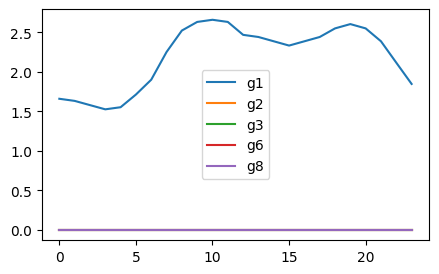

1056.1379260048172


In [7]:
sys=14
nT=24
data=read_data_ACOPF(File=f'IEEE_{sys}_bus_Data_PGLib_ACOPF.xlsx',DemFactor=1.0,print_data=False)
Bus=data['Bus']
G=data['G']

model=create_MultiTime_ACOPF_SOCP(data,nT=nT)

for b in data['Bus']:
    for t in range(0,nT):
        model.Pd[b,t].value = data['Pd_array'][Bus.index(b),t]
        model.Qd[b,t].value = data['Qd_array'][Bus.index(b),t]
        
    
solver = SolverFactory('gurobi_direct')
results = solver.solve(model,tee=False)

Pgt_array=np.zeros((len(G),nT))

for ind,g in enumerate(G):
    for t in range(0,nT):
        Pgt_array[ind,t]=model.Pg[g,t].value
        # print(g,t,model.Pg[g,t].value)




plt.figure(figsize=(5,3))
for ind,g in enumerate(G):
    plt.plot(range(0,nT),Pgt_array[ind,:],label=g)
plt.legend()
plt.show()

print( model.OF.value)

# Stochastic ACOPF - SOCP

In [12]:
def create_Stochastic_ACOPF(data,nT=24,NumSc=10,Ramp=True,Tlink=False):
    
    """Performs stochastic OPF
    Returns the Pg schedule for a given demand and time horizon considering cont_list
    if Pg0 is not None, considers the ramping limit to time 0!
    Pg0 is a numpy vector of dispathc values
    
    DemandInstance is a numpy array in the shape of (Scenarios,Bus,T).
    
    """
    
    #======  data
    
    Sbase=data['Sbase']
    Bus=data['Bus']    # for b in Bus
    branch=data['branch']
    Lines=data['Lines']
    L2B=data['L2B']
    Pdemand=data['Pdemand']
    DemandSet=data['Demandset']     # for d in Demand_set
    D2B=data['D2B']                  # for d,b in D2B
    Gen_data=data['Gen_data']
    G=data['G']             #for g in Gset
    G2B=data['G2B']               #for g,b in G2B
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']
    
    
        


    #======
        
    Senarios=range(0,NumSc)
    T=range(nT)
    EndTime=nT-1
    
    #
    
    
    model =  ConcreteModel(name='ACOPF')


    model.Pg = Var( G,T,Senarios,bounds=(0, None) )
    model.Qg = Var( G,T,Senarios,bounds=(None, None) )
    
    model.Pg_t0 = Var( G,bounds=(0, None) )
#     model.Qg_t0 = Var( G,bounds=(None, None) )
    
    model.Pd = Param(Senarios,Bus,T,initialize=0, mutable=True)
    model.Qd = Param(Senarios,Bus,T,initialize=0, mutable=True)
    if Tlink==True:
        model.Pg0 = Param(G,mutable=True)
    

    

    model.V2 = Var(Bus,T,Senarios,bounds=(0, None),initialize=1 )
    model.L2 = Var(Lines,T,Senarios,bounds=(0, None) )

    model.Pflow = Var( Lines,T,Senarios,bounds=(None, None) )
    model.Qflow = Var( Lines,T,Senarios,bounds=(None, None) )

  
    model.OF = Var( bounds=(0, None) )


    # equations
    vmin=0.9; vmax=1.1; 



    def eqPbalance(model,b,t,sc):
        return sum( model.Pg[g,t,sc] for g,b in G2B.select('*',b) ) - model.Pd[sc,b,t] \
        == sum(model.Pflow[l,i,j,t,sc] for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Pflow[l,i,j,t,sc]-branch.loc[(l,i,j)]['r']*model.L2[l,i,j,t,sc]         for l,i,j in Lines.select('*','*',b))
    model.eqPbalance=Constraint(Bus,T,Senarios,rule=eqPbalance)


    def eqQbalance(model,b,t,sc):
        return sum( model.Qg[g,t,sc] for g,b in G2B.select('*',b) ) - model.Qd[sc,b,t] \
        == sum(model.Qflow[l,i,j,t,sc]      for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Qflow[l,i,j,t,sc]-branch.loc[(l,i,j)]['x']*model.L2[l,i,j,t,sc]    for l,i,j in Lines.select('*','*',b))\
    #+0.5*branch.loc[(l,i,j)]['b_ij']*model.V2[b,t]
    
    model.eqQbalance=Constraint(Bus,T,Senarios,rule=eqQbalance)





    def eqSij(model,l,i,j,t,sc):
        return model.Pflow[l,i,j,t,sc]**2+model.Qflow[l,i,j,t,sc]**2 <= model.V2[i,t,sc]*model.L2[l,i,j,t,sc] 
    model.eqSij=Constraint(Lines,T,Senarios,rule=eqSij)

    
    def eqSij_V(model,l,i,j,t,sc):
        return model.V2[i,t,sc]-model.V2[j,t,sc] ==\
    -branch.loc[(l,i,j)]['z2']*model.L2[l,i,j,t,sc]\
    +2*(branch.loc[(l,i,j)]['r']*model.Pflow[l,i,j,t,sc] + branch.loc[(l,i,j)]['x']*model.Qflow[l,i,j,t,sc] )
    model.eqSij_V=Constraint(Lines,T,Senarios,rule=eqSij_V)



    def eqVmax(model,i,t,sc): return model.V2[i,t,sc]<= vmax**2
    model.eqVmax=Constraint(Bus,T,Senarios,rule=eqVmax)

    def eqVmin(model,i,t,sc): return vmin**2 <= model.V2[i,t,sc]
    model.eqVmin=Constraint(Bus,T,Senarios,rule=eqVmin)


    def eqPijmax(model,l,i,j,t,sc): 
        return model.Pflow[l,i,j,t,sc]*model.Pflow[l,i,j,t,sc] + model.Qflow[l,i,j,t,sc]*model.Qflow[l,i,j,t,sc]\
        <=branch.loc[(l,i,j)]['limit']**2
    model.eqPijmax=Constraint(Lines,T,Senarios,rule=eqPijmax)

    def eqPijmin(model,l,i,j,t,sc): 
        return -branch.loc[(l,i,j)]['limit']**2 <=\
        model.Pflow[l,i,j,t,sc]*model.Pflow[l,i,j,t,sc] + model.Qflow[l,i,j,t,sc]*model.Qflow[l,i,j,t,sc]
    model.eqPijmin=Constraint(Lines,T,Senarios,rule=eqPijmin)



    def eqPgmax(model,g,t,sc): return model.Pg[g,t,sc]<=Gen_data.loc[g]['Pmax']
    model.eqPgmax=Constraint(G,T,Senarios,rule=eqPgmax)

    def eqPgmin(model,g,t,sc): return Gen_data.loc[g]['Pmin'] <= model.Pg[g,t,sc]
    model.eqPgmin=Constraint(G,T,Senarios,rule=eqPgmin)

    def eqQgmax(model,g,t,sc): return model.Qg[g,t,sc]<= Gen_data.loc[g]['Qmax']
    model.eqQgmax=Constraint(G,T,Senarios,rule=eqQgmax)

    def eqQgmin(model,g,t,sc): return Gen_data.loc[g]['Qmin'] <= model.Qg[g,t,sc]
    model.eqQgmin=Constraint(G,T,Senarios,rule=eqQgmin)
    

    def eqPgt0(model,g,sc): return model.Pg[g,0,sc]==model.Pg_t0[g]
    model.eqPgt0=Constraint(G,Senarios,rule=eqPgt0)
    


    if Ramp==True:
        def eqRU(model,g,t,sc):
            if t!=EndTime:
                return model.Pg[g,t+1,sc]-model.Pg[g,t,sc]<=Gen_data.loc[g]['RampUp']  #+model.Rup[g,t+1]
            else:
                return Constraint.Skip
        model.eqRU=Constraint(G,T,Senarios,rule=eqRU)
        
        def eqRD(model,g,t,sc):
            if t!=EndTime:
                return model.Pg[g,t,sc]-model.Pg[g,t+1,sc]<=Gen_data.loc[g]['RampDn']  
            else:
                return Constraint.Skip
        model.eqRD=Constraint(G,T,Senarios,rule=eqRD)
        
        if Tlink==True:
            def eqPg0up(model,g):
                return model.Pg_t0[g]-model.Pg0[g]<=Gen_data.loc[g]['RampUp'] 
            model.eqPg0up=Constraint(G,rule=eqPg0up)
            
            def eqPg0dn(model,g):
                return model.Pg0[g] - model.Pg_t0[g]<=Gen_data.loc[g]['RampDn'] 
            model.eqPg0dn=Constraint(G,rule=eqPg0dn)




    model.eqOF = Constraint( expr = model.OF >= sum(Gen_data.loc[g]['b']*model.Pg[g,t,sc]  
                                                #+Gen_data.loc[g]['a']*model.Pg[g,t,sc]*model.Pg[g,t,sc]
                                                 + 0.0001*Gen_data.loc[g]['b']*model.Qg[g,t,sc]*model.Qg[g,t,sc] 
                                                    for g in G for t in T for sc in Senarios) )
    model.obj = Objective( expr = model.OF , sense=pyo.minimize      )


  
        
    return model
    

Stochastic_SC_OPF schedule


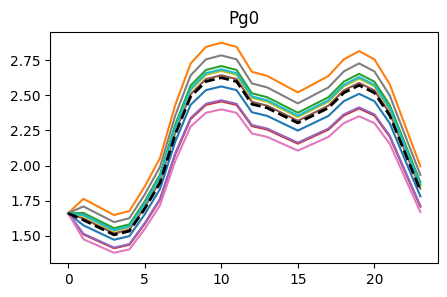

In [13]:
sys=14
nT=24
data=read_data_ACOPF(File=f'IEEE_{sys}_bus_Data_PGLib_ACOPF.xlsx',DemFactor=1.0,print_data=False)
Bus=data['Bus']
G=data['G']
NumSc=10
Senarios=range(NumSc)
T=range(nT)
Pd_array=data['Pd_array']
Qd_array=data['Qd_array']


# creating a demo stochastic scenario tree
Pd_sc_array=np.zeros((NumSc,Pd_array.shape[0],Pd_array.shape[1]))
Qd_sc_array=np.zeros((NumSc,Pd_array.shape[0],Pd_array.shape[1]))
np.random.seed(2023)
pi=np.random.uniform(0.9,1.1,size=(NumSc))
for sc in Senarios:
    Pd_sc_array[sc,:,:]=pi[sc]*Pd_array
    Pd_sc_array[sc,:,0]=Pd_array[:,0]
    Qd_sc_array[sc,:,:]=pi[sc]*Qd_array
    Qd_sc_array[sc,:,0]=Qd_array[:,0]
   

model=create_Stochastic_ACOPF(data,NumSc=NumSc)

        
for b in Bus:
    for t in T:
        for sc in Senarios:
            model.Pd[sc,b,t].value = Pd_sc_array[sc,Bus.index(b),t]  
            model.Qd[sc,b,t].value = Qd_sc_array[sc,Bus.index(b),t]
        
  
solver = SolverFactory('ipopt')
results = solver.solve(model,tee=False)

#report



Pgt_array=np.zeros((len(Senarios),len(G),len(T)))
    
for ind,g in enumerate(G):
    for t in T:
        for sc in Senarios:
            Pgt_array[sc,ind,t]=model.Pg[g,t,sc].value




print('Stochastic_SC_OPF schedule')
plt.figure(figsize=(5,3))

g_index=0
for sc in Senarios:
    plt.plot(T,Pgt_array[sc,g_index,:],label=sc)
plt.plot(Pgt_array[:,g_index,:].mean(axis=0), linestyle='dashed' , linewidth=2, color='black' ,label='mean')
plt.title('Pg'+str(g_index))
plt.show()

# ADMM-based stochastic ACOPF

In [19]:
def create_XUpdate_Stochastic_ACOPF(data,nT=24,NumSc=10,rho=1,   
                           Ramp=True,Tlink=False):
    """This function is used for single case studies and execution time."""
    
    #======  data
    
    Sbase=data['Sbase']
    Bus=data['Bus']    # for b in Bus
    branch=data['branch']
    Lines=data['Lines']
    L2B=data['L2B']
    Pdemand=data['Pdemand']
    DemandSet=data['Demandset']     # for d in Demand_set
    D2B=data['D2B']                  # for d,b in D2B
    Gen_data=data['Gen_data']
    G=data['G']             #for g in Gset
    G2B=data['G2B']               #for g,b in G2B
#     EndTime=data['EndTime']
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']
    
    
        


    #======
        
    Senarios=range(0,NumSc)
    T=range(nT)
    EndTime=nT-1
        
    
    #====
    
    model =  ConcreteModel(name='ACOPF')


    model.Pg = Var( G,T,bounds=(0, None) )
    model.Qg = Var( G,T,bounds=(None, None) )
    
    
    model.lambdaP = Param(Senarios,G,initialize=0, mutable=True)
    model.PgZ = Param(Senarios,G,initialize=0, mutable=True)
    
#     model.lambdaQ = Param(Bus,T,initialize=0, mutable=True)
    
    model.Pd = Param(Bus,T,initialize=0, mutable=True)
    model.Qd = Param(Bus,T,initialize=0, mutable=True)
    if Tlink==True:
        model.Pg0 = Param(G,mutable=True)
    
    

    model.V2 = Var(Bus,T,bounds=(0, None),initialize=1 )
    model.L2 = Var(Lines,T,bounds=(0, None) )

    model.Pflow = Var( Lines,T,bounds=(None, None) )
    model.Qflow = Var( Lines,T,bounds=(None, None) )


    model.OF = Var( bounds=(0, None) )

    #initialize
#     if Pg0 != None:
#         for g in G:
#             model.Pg0[g].value=Pg0[g]
#             for t in T:
#                 model.Pg[g,t].value=Pg0[g]



    # equations
    vmin=0.9; vmax=1.1; 



    def eqPbalance(model,b,t):
        return sum( model.Pg[g,t] for g,b in G2B.select('*',b) ) - model.Pd[b,t] \
        == sum(model.Pflow[l,i,j,t] for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Pflow[l,i,j,t]-branch.loc[(l,i,j)]['r']*model.L2[l,i,j,t]         for l,i,j in Lines.select('*','*',b))
    model.eqPbalance=Constraint(Bus,T,rule=eqPbalance)


    def eqQbalance(model,b,t):
        return sum( model.Qg[g,t] for g,b in G2B.select('*',b) ) - model.Qd[b,t] \
        == sum(model.Qflow[l,i,j,t]      for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Qflow[l,i,j,t]-branch.loc[(l,i,j)]['x']*model.L2[l,i,j,t]    for l,i,j in Lines.select('*','*',b))\
    #+0.5*branch.loc[(l,i,j)]['b_ij']*model.V2[b,t]
    
    model.eqQbalance=Constraint(Bus,T,rule=eqQbalance)




    def eqSij(model,l,i,j,t):
        return model.Pflow[l,i,j,t]**2+model.Qflow[l,i,j,t]**2 <= model.V2[i,t]*model.L2[l,i,j,t] 
    model.eqSij=Constraint(Lines,T,rule=eqSij)

    #
    def eqSij_V(model,l,i,j,t):
        return model.V2[i,t]-model.V2[j,t] ==\
    -branch.loc[(l,i,j)]['z2']*model.L2[l,i,j,t]\
    +2*(branch.loc[(l,i,j)]['r']*model.Pflow[l,i,j,t] + branch.loc[(l,i,j)]['x']*model.Qflow[l,i,j,t] )
    model.eqSij_V=Constraint(Lines,T,rule=eqSij_V)




    def eqVmax(model,i,t): return model.V2[i,t]<= vmax**2
    model.eqVmax=Constraint(Bus,T,rule=eqVmax)

    def eqVmin(model,i,t): return vmin**2 <= model.V2[i,t]
    model.eqVmin=Constraint(Bus,T,rule=eqVmin)


    def eqPijmax(model,l,i,j,t): 
        return model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]\
        <=branch.loc[(l,i,j)]['limit']**2
    model.eqPijmax=Constraint(Lines,T,rule=eqPijmax)

    def eqPijmin(model,l,i,j,t): 
        return -branch.loc[(l,i,j)]['limit']**2 <=\
        model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]
    model.eqPijmin=Constraint(Lines,T,rule=eqPijmin)



    def eqPgmax(model,g,t): return model.Pg[g,t]<=Gen_data.loc[g]['Pmax']
    model.eqPgmax=Constraint(G,T,rule=eqPgmax)

    def eqPgmin(model,g,t): return Gen_data.loc[g]['Pmin'] <= model.Pg[g,t]
    model.eqPgmin=Constraint(G,T,rule=eqPgmin)

    def eqQgmax(model,g,t): return model.Qg[g,t]<= Gen_data.loc[g]['Qmax']
    model.eqQgmax=Constraint(G,T,rule=eqQgmax)

    def eqQgmin(model,g,t): return Gen_data.loc[g]['Qmin'] <= model.Qg[g,t]
    model.eqQgmin=Constraint(G,T,rule=eqQgmin)

    
    


    if Ramp==True:
        def eqRU(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t+1]-model.Pg[g,t]<=Gen_data.loc[g]['RampUp']  #+model.Rup[g,t+1]
            else:
                return Constraint.Skip
        model.eqRU=Constraint(G,T,rule=eqRU)
        
        def eqRD(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t]-model.Pg[g,t+1]<=Gen_data.loc[g]['RampDn']  
            else:
                return Constraint.Skip
        model.eqRD=Constraint(G,T,rule=eqRD)
        
        if Tlink==True:
            def eqPg0up(model,g):
                return model.Pg[g,T[0]]-model.Pg0[g]<=Gen_data.loc[g]['RampUp'] 
            model.eqPg0up=Constraint(G,rule=eqPg0up)
            
            def eqPg0dn(model,g):
                return model.Pg0[g] - model.Pg[g,T[0]]<=Gen_data.loc[g]['RampDn'] 
            model.eqPg0dn=Constraint(G,rule=eqPg0dn)




    model.eqOF = Constraint( expr = model.OF >= sum(Gen_data.loc[g]['b']*model.Pg[g,t]
                                                #+Gen_data.loc[g]['a']*model.Pg[g,t]*model.Pg[g,t]
                                                 + 0.0001*Gen_data.loc[g]['b']*model.Qg[g,t]*model.Qg[g,t] 
                                                    for g in G for t in T)
                    +sum( model.lambdaP[sc,g]*(model.Pg[g,0]-model.PgZ[sc,g]) 
                         + 0.5*rho*(model.Pg[g,0]-model.PgZ[sc,g])**2    for g in G for sc in Senarios) )
    
    
    model.obj = Objective( expr = model.OF , sense=pyo.minimize      )
    
    
    
    
    return model


In [20]:
def Solve_Xupdate_ACOPF(data,modelX,Pd_sc_array,PgZ,lambda_s):
    
    
    Bus=data['Bus']
    G=data['G']
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']
    
    nT=Pd_sc_array.shape[2]
    NumSc=Pd_sc_array.shape[0]
    
    
    solver = SolverFactory('gurobi_direct')
    
    Qd_sc_array=Pd_sc_array.copy()
        
    for b_ind in range(len(Bus)):
        if Pd_array[b_ind,0]!=0:
            Qd_sc_array[:,b_ind,:] = Pd_sc_array[:,b_ind,:]*(Qd_array[b_ind,0]/Pd_array[b_ind,0])

    
    
    for b_ind,b in enumerate(Bus):
        for t in range(nT):
            modelX.Pd[b,t].value=Pd_sc_array[:,b_ind,t].mean()
            modelX.Qd[b,t].value=Qd_sc_array[:,b_ind,t].mean()    
    

    for sc in range(NumSc):
        for g_ind,g in enumerate(G):
            modelX.PgZ[sc,g].value = PgZ[sc,g_ind]
            modelX.lambdaP[sc,g].value = lambda_s[sc,g_ind]
    
    
    


    results = solver.solve(modelX,tee=False) 
    
    ex_time = results['Solver'][0]['Time']
    
    
    Pgt_array=np.zeros((len(G),nT))
    for ind,g in enumerate(G):
        for t in range(nT):
            Pgt_array[ind,t]=modelX.Pg[g,t].value
    
    
    return {
        'Pg':Pgt_array,
        'time':ex_time
        }
    

In [21]:
def create_ZUpdate_Stochastic_ACOPF(data,nT=24,rho=1,
                           Ramp=True,Tlink=False):
    
    """
    This function is used for single case studies!
    Returns the Pg schedule for a given demand and time horizon
    if Pg0 is not None, considers the ramping limit to time 0!
    Pg0 is a numpy vector of dispathc values"""
    
    #======  data
    
    Sbase=data['Sbase']
    Bus=data['Bus']    # for b in Bus
    branch=data['branch']
    Lines=data['Lines']
    L2B=data['L2B']
    Pdemand=data['Pdemand']
    DemandSet=data['Demandset']     # for d in Demand_set
    D2B=data['D2B']                  # for d,b in D2B
    Gen_data=data['Gen_data']
    G=data['G']             #for g in Gset
    G2B=data['G2B']               #for g,b in G2B
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']
    
    
    
    #======
        
    Senarios=range(0,NumSc)
    T=range(nT)
    EndTime=nT-1
    
    #
    
    
    #====
    
    model =  ConcreteModel(name='Z_StACOPF')


    model.Pg = Var( G,T,bounds=(0, None) )
    model.Qg = Var( G,T,bounds=(None, None) )
    
    
    model.lambdaP = Param(G,initialize=0, mutable=True)
    model.PgX = Param(G,initialize=0, mutable=True)
    
    
    model.Pd = Param(Bus,T,initialize=0, mutable=True)
    model.Qd = Param(Bus,T,initialize=0, mutable=True)
    if Tlink==True:
        model.Pg0 = Param(G,mutable=True)
    
    

    model.V2 = Var(Bus,T,bounds=(0, None),initialize=1 )
    model.L2 = Var(Lines,T,bounds=(0, None) )

    model.Pflow = Var( Lines,T,bounds=(None, None) )
    model.Qflow = Var( Lines,T,bounds=(None, None) )


    model.OF = Var( bounds=(0, None) )

    #initialize
#     if Pg0 != None:
#         for g in G:
#             model.Pg0[g].value=Pg0[g]
#             for t in T:
#                 model.Pg[g,t].value=Pg0[g]



    # equations
    vmin=0.9; vmax=1.1; 



    def eqPbalance(model,b,t):
        return sum( model.Pg[g,t] for g,b in G2B.select('*',b) ) - model.Pd[b,t] \
        == sum(model.Pflow[l,i,j,t] for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Pflow[l,i,j,t]-branch.loc[(l,i,j)]['r']*model.L2[l,i,j,t]         for l,i,j in Lines.select('*','*',b))
    model.eqPbalance=Constraint(Bus,T,rule=eqPbalance)


    def eqQbalance(model,b,t):
        return sum( model.Qg[g,t] for g,b in G2B.select('*',b) ) - model.Qd[b,t] \
        == sum(model.Qflow[l,i,j,t]      for l,i,j in Lines.select('*',b,'*'))\
    -sum(model.Qflow[l,i,j,t]-branch.loc[(l,i,j)]['x']*model.L2[l,i,j,t]    for l,i,j in Lines.select('*','*',b))\
    #+0.5*branch.loc[(l,i,j)]['b_ij']*model.V2[b,t]
    
    model.eqQbalance=Constraint(Bus,T,rule=eqQbalance)




    def eqSij(model,l,i,j,t):
        return model.Pflow[l,i,j,t]**2+model.Qflow[l,i,j,t]**2 <= model.V2[i,t]*model.L2[l,i,j,t] 
    model.eqSij=Constraint(Lines,T,rule=eqSij)

    #
    def eqSij_V(model,l,i,j,t):
        return model.V2[i,t]-model.V2[j,t] ==\
    -branch.loc[(l,i,j)]['z2']*model.L2[l,i,j,t]\
    +2*(branch.loc[(l,i,j)]['r']*model.Pflow[l,i,j,t] + branch.loc[(l,i,j)]['x']*model.Qflow[l,i,j,t] )
    model.eqSij_V=Constraint(Lines,T,rule=eqSij_V)



    def eqVmax(model,i,t): return model.V2[i,t]<= vmax**2
    model.eqVmax=Constraint(Bus,T,rule=eqVmax)

    def eqVmin(model,i,t): return vmin**2 <= model.V2[i,t]
    model.eqVmin=Constraint(Bus,T,rule=eqVmin)


    def eqPijmax(model,l,i,j,t): 
        return model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]\
        <=branch.loc[(l,i,j)]['limit']**2
    model.eqPijmax=Constraint(Lines,T,rule=eqPijmax)

    def eqPijmin(model,l,i,j,t): 
        return -branch.loc[(l,i,j)]['limit']**2 <=\
        model.Pflow[l,i,j,t]*model.Pflow[l,i,j,t] + model.Qflow[l,i,j,t]*model.Qflow[l,i,j,t]
    model.eqPijmin=Constraint(Lines,T,rule=eqPijmin)



    def eqPgmax(model,g,t): return model.Pg[g,t]<=Gen_data.loc[g]['Pmax']
    model.eqPgmax=Constraint(G,T,rule=eqPgmax)

    def eqPgmin(model,g,t): return Gen_data.loc[g]['Pmin'] <= model.Pg[g,t]
    model.eqPgmin=Constraint(G,T,rule=eqPgmin)

    def eqQgmax(model,g,t): return model.Qg[g,t]<= Gen_data.loc[g]['Qmax']
    model.eqQgmax=Constraint(G,T,rule=eqQgmax)

    def eqQgmin(model,g,t): return Gen_data.loc[g]['Qmin'] <= model.Qg[g,t]
    model.eqQgmin=Constraint(G,T,rule=eqQgmin)

    
    


    if Ramp==True:
        def eqRU(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t+1]-model.Pg[g,t]<=Gen_data.loc[g]['RampUp']  #+model.Rup[g,t+1]
            else:
                return Constraint.Skip
        model.eqRU=Constraint(G,T,rule=eqRU)
        
        def eqRD(model,g,t):
            if t!=EndTime:
                return model.Pg[g,t]-model.Pg[g,t+1]<=Gen_data.loc[g]['RampDn']  
            else:
                return Constraint.Skip
        model.eqRD=Constraint(G,T,rule=eqRD)
        
        if Tlink==True:
            def eqPg0up(model,g):
                return model.Pg[g,T[0]]-model.Pg0[g]<=Gen_data.loc[g]['RampUp'] 
            model.eqPg0up=Constraint(G,rule=eqPg0up)
            
            def eqPg0dn(model,g):
                return model.Pg0[g] - model.Pg[g,T[0]]<=Gen_data.loc[g]['RampDn'] 
            model.eqPg0dn=Constraint(G,rule=eqPg0dn)



    model.eqOF = Constraint( expr = model.OF >= sum(Gen_data.loc[g]['b']*model.Pg[g,t]  \
                                                #+Gen_data.loc[g]['a']*model.Pg[g,t]*model.Pg[g,t]
                                                 + 0.0001*Gen_data.loc[g]['b']*model.Qg[g,t]*model.Qg[g,t] 
                                                    for g in G for t in T)
                    +sum( model.lambdaP[g]*(model.PgX[g]-model.Pg[g,0]) 
                         + 0.5*rho*(model.PgX[g]-model.Pg[g,0])**2    for g in G)       )
    
    
    model.obj = Objective( expr = model.OF , sense=pyo.minimize      )
    


        
    return model


# Main ADMM function for Stochastic ACOPF

In [27]:
def Solve_ADMM_Stochastic_ACOPF(data,k_iter=10,modelX=None,modelZ=None,
                           lambda_initial=None,PgX_initial=None,PgZ_initial=None,
                        rho=0.1,
                        lambda_std=0.3,exploration=False,explore_iter=0,exp_decay=0.1,
                        Ramp=True,DemandInstnace=None,print_result=False):
    
    """This function is used for single case studies and execution time test.
    Xmulti=True means that we used multi-SCOPF for XUpdate. For timing purposes the Xmulti=False is used."""
    
     #======  data
    
    Sbase=data['Sbase']
    Bus=data['Bus']    # for b in Bus
    branch=data['branch']
    Lines=data['Lines']
    L2B=data['L2B']
    Pdemand=data['Pdemand']
    DemandSet=data['Demandset']     # for d in Demand_set
    D2B=data['D2B']                  # for d,b in D2B
    Gen_data=data['Gen_data']
    G=data['G']             #for g in Gset
    G2B=data['G2B']               #for g,b in G2B
    Pd_array=data['Pd_array']
    Qd_array=data['Qd_array']
    
    
    
    #======

    

    # change here! 
    if DemandInstnace is not None:
        Pd_sc_array=DemandInstnace.copy() #shape [Sc,Bus,T]
        Qd_sc_array=Pd_sc_array.copy()
        
        for b_ind in range(len(Bus)):
            if Pd_array[b_ind,0]!=0:
                Qd_sc_array[:,b_ind,:] = Pd_sc_array[:,b_ind,:]*(Qd_array[b_ind,0]/Pd_array[b_ind,0])
            
        nT=Pd_sc_array.shape[2]
        T=range(0,nT) #0 to 23
        
        
        NumSc=Pd_sc_array.shape[0]
        Senarios=range(0,NumSc)
    else:
        print('No demand input!!')

            
            
    k_iter_list=range(k_iter)
    residual={'rk':[],'sk':[]}
    
    
    
    
    ## ======================== Initialization =========================================

    
#     Multi_OPF() for average scenarios


    PgX=np.zeros((len(G)))
    PgZ=np.zeros((NumSc,len(G),len(T))) # => we pass PgZ[:,g,0] to X-Update

    PgX_k=np.zeros(( k_iter,len(G),len(T))) #shape [ADMM_iter,G,T] we do MP-OPF for better convergence
    PgZ_k = np.zeros((k_iter,NumSc,len(G),len(T))) # => shape [ADMM_iter,Sc,G,T]

    if lambda_initial is None:
        lambda_s=np.random.normal(0,lambda_std,size=(NumSc,len(G)))
    else:
        lambda_s = lambda_initial
        
    lambda_k=np.zeros((k_iter,NumSc,len(G))) #shape [ADMM_iter,Sc,G]
    
    exp_mask = np.random.uniform(0,1,size=(k_iter,NumSc,len(G))) #if exp_mask > exp_threshold, then exploit! 
    exp_threshold = 1.0
    
    
    Time_X_k=np.zeros(k_iter) #(k,)
    Time_Z_k=np.zeros((k_iter,NumSc)) #(k,sc)
    
    
    
    if modelX is None:
        modelX=create_XUpdate_Stochastic_ACOPF(data, NumSc=NumSc,nT=nT,rho=rho,Ramp=Ramp,Tlink=False)
    if modelZ is None:
        modelZ=create_ZUpdate_Stochastic_ACOPF(data,nT=nT,rho=rho,Ramp=Ramp,Tlink=False)

    
    #initialization
    if PgX_initial is None:
        PgX_initial = np.zeros((len(G)))
    if PgZ_initial is None:
        PgZ_initial=np.zeros((NumSc,len(G),len(T)))
        
    PgZ = PgZ_initial.copy()
    PgX = PgX_initial.copy()
    
    
    for b_ind,b in enumerate(Bus):
        for t in T:
            modelX.Pd[b,t].value=Pd_sc_array[:,b_ind,t].mean()
            modelX.Qd[b,t].value=Qd_sc_array[:,b_ind,t].mean()
#             for sc in Senarios:
#                 modelZ.Pd[sc,b,t].value=Pd_sc_array[sc,b_ind,t]
#                 modelZ.Qd[sc,b,t].value=Qd_sc_array[sc,b_ind,t]

    solver = SolverFactory('IPOPT')            
    solver = SolverFactory('gurobi_direct') #you can use different solvers
    
    
    ## ======================== ADMM loop =========================================

    start_time = time.time()

    for k in range(k_iter):
    
#         print('\n===== ADMM iteration ',k)
    
    #============= X-Update ==============================================
    
        for sc in Senarios:
            for g_ind,g in enumerate(G):
                modelX.PgZ[sc,g].value = PgZ[sc,g_ind,0]
                modelX.lambdaP[sc,g].value = lambda_s[sc,g_ind]
                
        
        results = solver.solve(modelX,tee=False) 
        Time_X_k[k] = results['Solver'][0]['Time'] # this line has to change based on the solver used
                             
        for ind,g in enumerate(G):
            PgX[ind]=modelX.Pg[g,0].value
            for t in T:
                PgX_k[k,ind,t]=modelX.Pg[g,t].value
            

    #============= Z-Update ==============================================
                             
        for g_ind,g in enumerate(G):
            modelZ.PgX[g].value = PgX[g_ind]
        # zupdate sc                     
        for sc in Senarios:
            if print_result==True:
                print('===== iteration %3s scenario %3s'%(k,sc),end='\r')
            
            for b_ind,b in enumerate(Bus):
                for t in T:
                    modelZ.Pd[b,t].value=Pd_sc_array[sc,b_ind,t]
                    modelZ.Qd[b,t].value=Qd_sc_array[sc,b_ind,t]
                    modelZ.lambdaP[g].value = lambda_s[sc,g_ind]
            
                    
            results = solver.solve(modelZ,tee=False) #solve z-update
            Time_Z_k[k,sc] = results['Solver'][0]['Time']
                             
            
            for ind,g in enumerate(G):
                lambda_s[sc,ind] = modelZ.lambdaP[g].value+ rho*(modelZ.PgX[g].value - modelZ.Pg[g,0].value)
                for t in T:
                    PgZ[sc,ind,t]=modelZ.Pg[g,t].value      
                             

        # all scenarios done
                             
        if exploration == False or k >= explore_iter:
            lambda_s=lambda_s 
        elif exploration == True and k < explore_iter:
            lambda_s_rand = np.random.normal(0,lambda_std,size=(NumSc,len(G)))
            exp_threshold = exp_threshold - exp_decay
            for sc in range(NumSc):
                for g in range(len(G)):
                    if exp_mask[k,sc,g] <= exp_threshold:
                        lambda_s[sc,g] = lambda_s_rand[sc,g] #explore
                    else:
                        lambda_s[sc,g] = lambda_s[sc,g]
        
            
                
        #============= Residuals ==============================================
    
        # k_update
        PgZ_k[k]=PgZ
        

        
        
        rk_now=np.square(np.absolute(PgX - PgZ[:,:,0])).mean()

        residual['rk']+=[rk_now]
        


    
    
    end_time = time.time()
    ex_time=end_time-start_time  #execution time


    if print_result==True:
        print("\n******* finished!!! ********")
        print("ADMM time: %.3f sec"%ex_time)
    
    

        plt.figure(figsize=(5,3))

        plt.plot(range(k_iter), residual['rk']   )

        plt.title('Residuals',fontsize=15)
        plt.xlabel('Iteration k',fontsize=12)
        plt.yscale('log')
    #     plt.grid(ls='--')
        plt.show('Plot1')
        
        

    #     plt.grid(ls='--')
        plt.figure(figsize=(5,3))
        for sc in Senarios:
            plt.plot(PgZ[sc,0,:],label=sc)
        plt.plot(PgZ[:,0,:].mean(axis=0), linestyle='dashed' , linewidth=2, color='black' ,label='mean')
        # plt.legend()
        plt.title('G1 for sc')
        plt.show()
    
    
    
    return {
        'PgZ':PgZ, 
        'PgX':PgX,
        'PgX_k':PgX_k, #shape [ADMM_iter,G,T]
        'PgZ_k':PgZ_k, #shape [ADMM_iter,Sc,G,T]
        'lambda_k':lambda_k, #shape [ADMM_iter,Sc,G]
        'rk':residual['rk'], #[ADMM_iter]
        'Time_X_k':Time_X_k,
        'Time_Z_k':Time_Z_k
    }
    
    

===== iteration   9 scenario   4
******* finished!!! ********
ADMM time: 16.372 sec


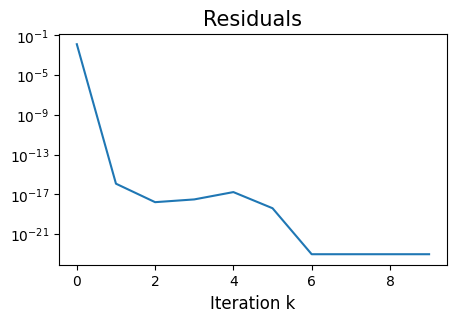

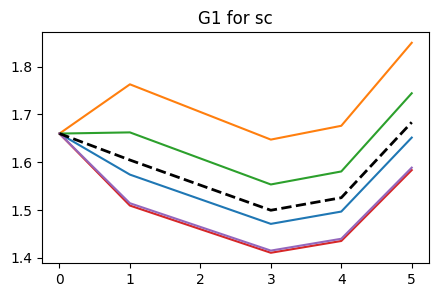

In [26]:
sys=14
nT=6
data=read_data_ACOPF(File=f'IEEE_{sys}_bus_Data_PGLib_ACOPF.xlsx',DemFactor=1.0,print_data=False)
Bus=data['Bus']
G=data['G']
NumSc=5
Senarios=range(NumSc)
T=range(nT)
Pd_array=data['Pd_array']


Pd_sc_array=np.zeros((NumSc,Pd_array.shape[0],Pd_array.shape[1]))
np.random.seed(2023)
pi=np.random.uniform(0.9,1.1,size=(NumSc))
for sc in Senarios:
    Pd_sc_array[sc,:,:]=pi[sc]*Pd_array
    Pd_sc_array[sc,:,0]=Pd_array[:,0]
    
    
result=Solve_ADMM_Stochastic_ACOPF(data,k_iter=10,DemandInstnace=Pd_sc_array[:,:,:nT],print_result=True,
                                   exploration=True,explore_iter=5,exp_decay=0)

# End